<h1 style="color:orange">EXERCISE CLASS 8 - Multivariate SPC </h1>
(Chapter 11, Montgomery)

# EXERCISE 1

A boatyard manager decided to measure the paint width (mm) and the corrosion speed
(mm/year) to determine when the boat needs to be re-painted. They selected ten boats
on which the measures of controlled parameters were performed in three predefined
locations. The experiment lasted for two months and the relative collected data are 
in the file `ESE8_ex1.csv`.

Design an appropriate control chart and verify if the 9th sample is IC or OOC.


# SOLUTION

> Let's start by importing the required libraries and loading the data.

In [1]:
# Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats

# Import the dataset
data = pd.read_csv('ESE8_ex1.csv')

# Inspect the dataset
data.head()

Boat  Width1  Width2  Width3  Corr.speed1  Corr.speed2  Corr.speed3
0     1    2.14    2.01    1.88         0.33         0.47         0.50
1     2    1.96    1.91    1.94         0.37         0.62         0.37
2     3    1.93    1.86    1.99         0.54         0.57         0.39
3     4    1.94    1.96    1.86         0.52         0.45         0.72
4     5    1.94    2.13    2.17         0.66         0.53         0.33

> First of all we check the Marginal Normality of the stacked values of `Width` and `Corr.speed`

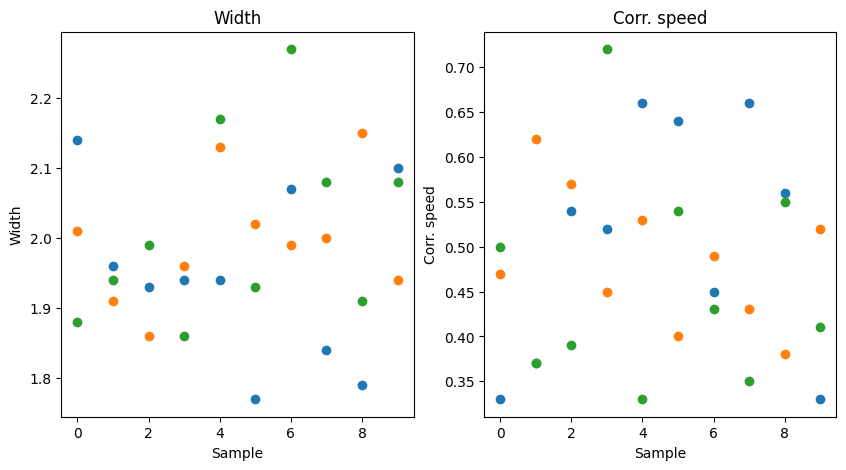

In [2]:
# Extract the stacked array
Width = data[['Width1', 'Width2', 'Width3']]
Corr_speed = data[['Corr.speed1', 'Corr.speed2', 'Corr.speed3']]

# Plot the data
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(Width, 'o')
ax[0].set_xlabel('Sample')
ax[0].set_ylabel('Width')
ax[0].set_title('Width')
ax[1].plot(Corr_speed, 'o')
ax[1].set_xlabel('Sample')
ax[1].set_ylabel('Corr. speed')
ax[1].set_title('Corr. speed')
plt.show()

Shapiro-Wilk test on Width p-value = 0.704


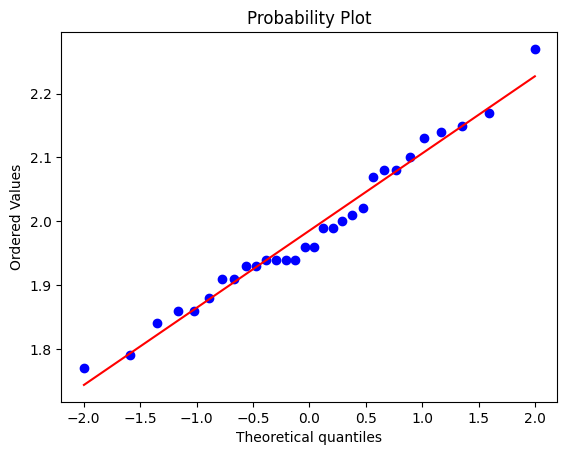

In [3]:
# Perform the Shapiro-Wilk test on the Width
_, pval1_SW = stats.shapiro(Width.stack())
print('Shapiro-Wilk test on Width p-value = %.3f' % pval1_SW)

# Plot the qqplot
stats.probplot(Width.stack(), dist="norm", plot=plt)
plt.show()


Shapiro-Wilk test on Corr.speed p-value = 0.249


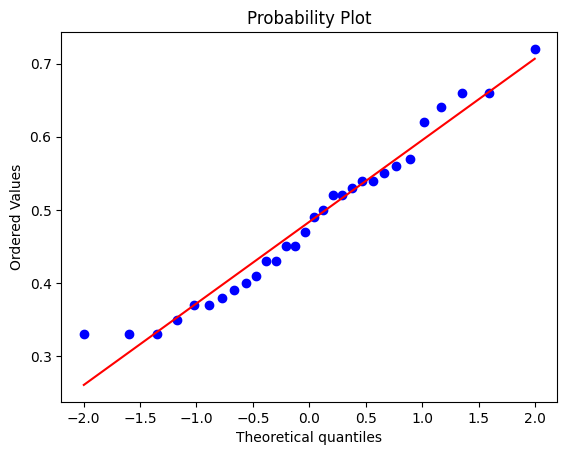

In [4]:
# Perform the Shapiro-Wilk test on the Corr.speed
_, pval2_SW = stats.shapiro(Corr_speed.stack())
print('Shapiro-Wilk test on Corr.speed p-value = %.3f' % pval2_SW)

# Plot the qqplot
stats.probplot(Corr_speed.stack(), dist="norm", plot=plt)
plt.show()

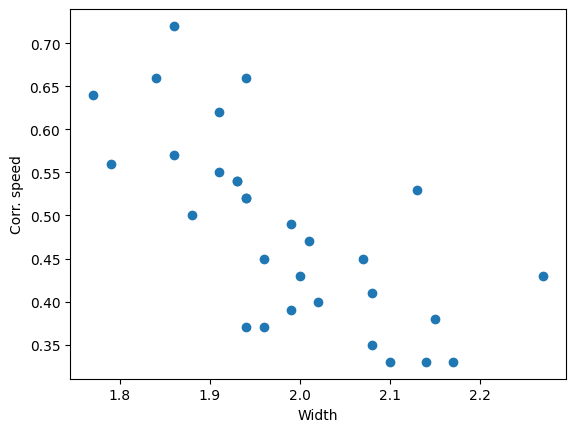

In [5]:
# Plot the data
plt.scatter(Width, Corr_speed)
plt.xlabel('Width')
plt.ylabel('Corr. speed')
plt.show()

> Remember the Hotelling's CC:

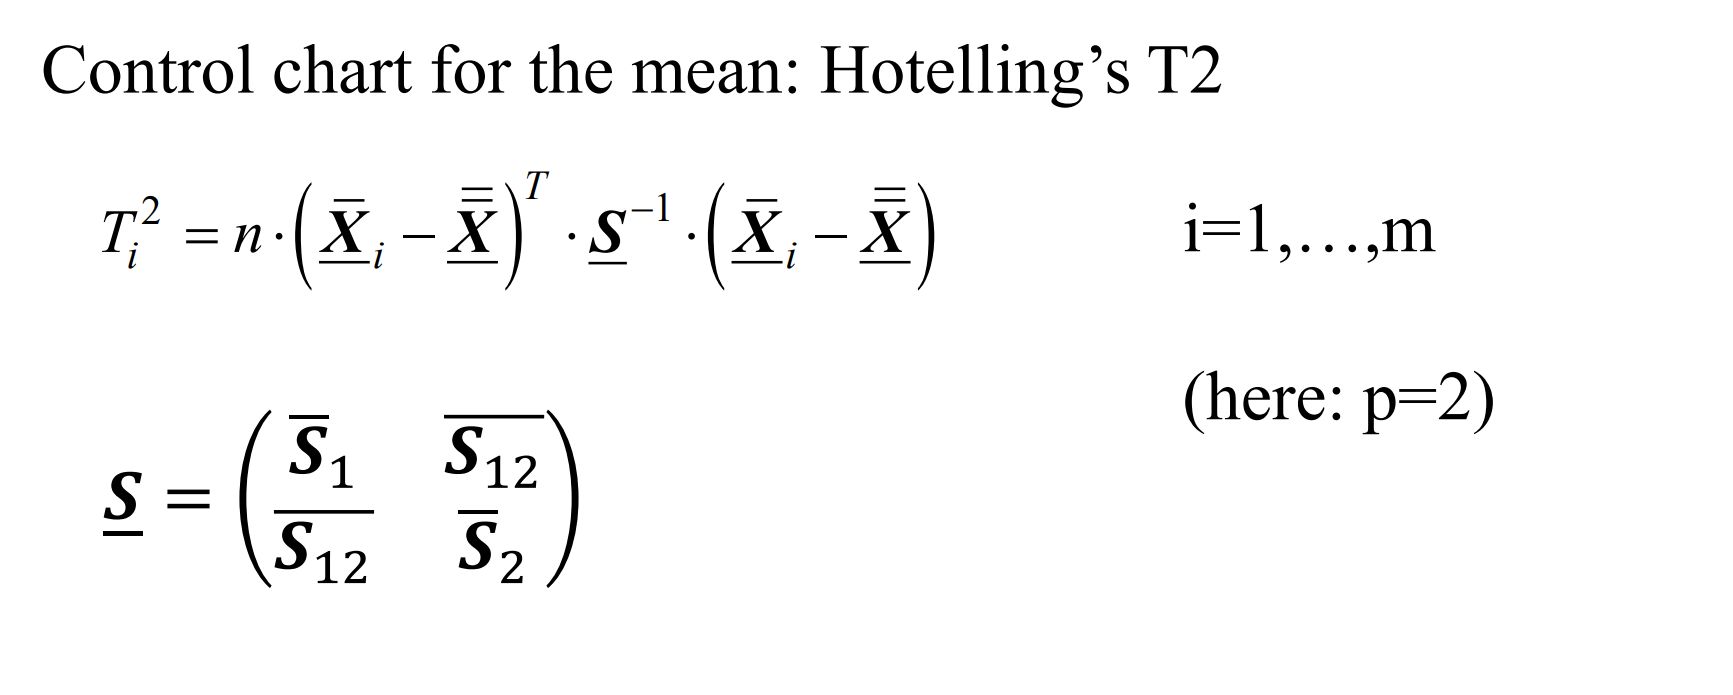

> Assuming that the data follow a binomial distribution, letâ€™s estimate the grand mean vector **X** and the variance/covariance matrix **S**

> Compute the grand mean vector, $\underline{\overline{\overline{\mathbf{X}}}}$.

In [6]:
# Create a new dataframe to store the sample mean
sample_mean = pd.DataFrame()
sample_mean['width'] = Width.mean(axis=1)
sample_mean['corr_speed'] = Corr_speed.mean(axis=1)

# Calculate the grand mean
Xbarbar = sample_mean.mean()
print(Xbarbar)

width         1.985333
corr_speed    0.483667
dtype: float64


> Now compute the variance/covariance matrix, $\underline{\mathbf{S}}$.

In [7]:
# Create a new dataframe to store the stacked data
data_stack = pd.DataFrame()
data_stack[['sample', 'width']] = Width.transpose().melt()
data_stack['corr_speed'] = Corr_speed.transpose().melt()['value']

data_stack.head(9)

sample  width  corr_speed
0       0   2.14        0.33
1       0   2.01        0.47
2       0   1.88        0.50
3       1   1.96        0.37
4       1   1.91        0.62
5       1   1.94        0.37
6       2   1.93        0.54
7       2   1.86        0.57
8       2   1.99        0.39

In [8]:
# Compute the variance and covariance matrix of each group (sample)
cov_matrix = data_stack.groupby('sample').cov()

cov_matrix.head(8)

width  corr_speed
sample                                 
0      width       0.016900   -0.011050
       corr_speed -0.011050    0.008233
1      width       0.000633   -0.003333
       corr_speed -0.003333    0.020833
2      width       0.004233   -0.005750
       corr_speed -0.005750    0.009300
3      width       0.002800   -0.007400
       corr_speed -0.007400    0.019633

In [9]:
# Compute the mean covariance matrix
S = cov_matrix.groupby(level=1).mean()

print(S)

               width  corr_speed
corr_speed -0.010970    0.014633
width       0.013263   -0.010970


> Attention! The indeces are now in alphabetic order. We need to reorder them in the order of the variables to get the correct variance/covariance matrix.

In [10]:
# Reorder the indeces of S to match the order of the columns
# get the names of the columns
cols = S.columns.tolist()

S = S.reindex(columns=cols, index=cols)

print(S)

               width  corr_speed
width       0.013263   -0.010970
corr_speed -0.010970    0.014633


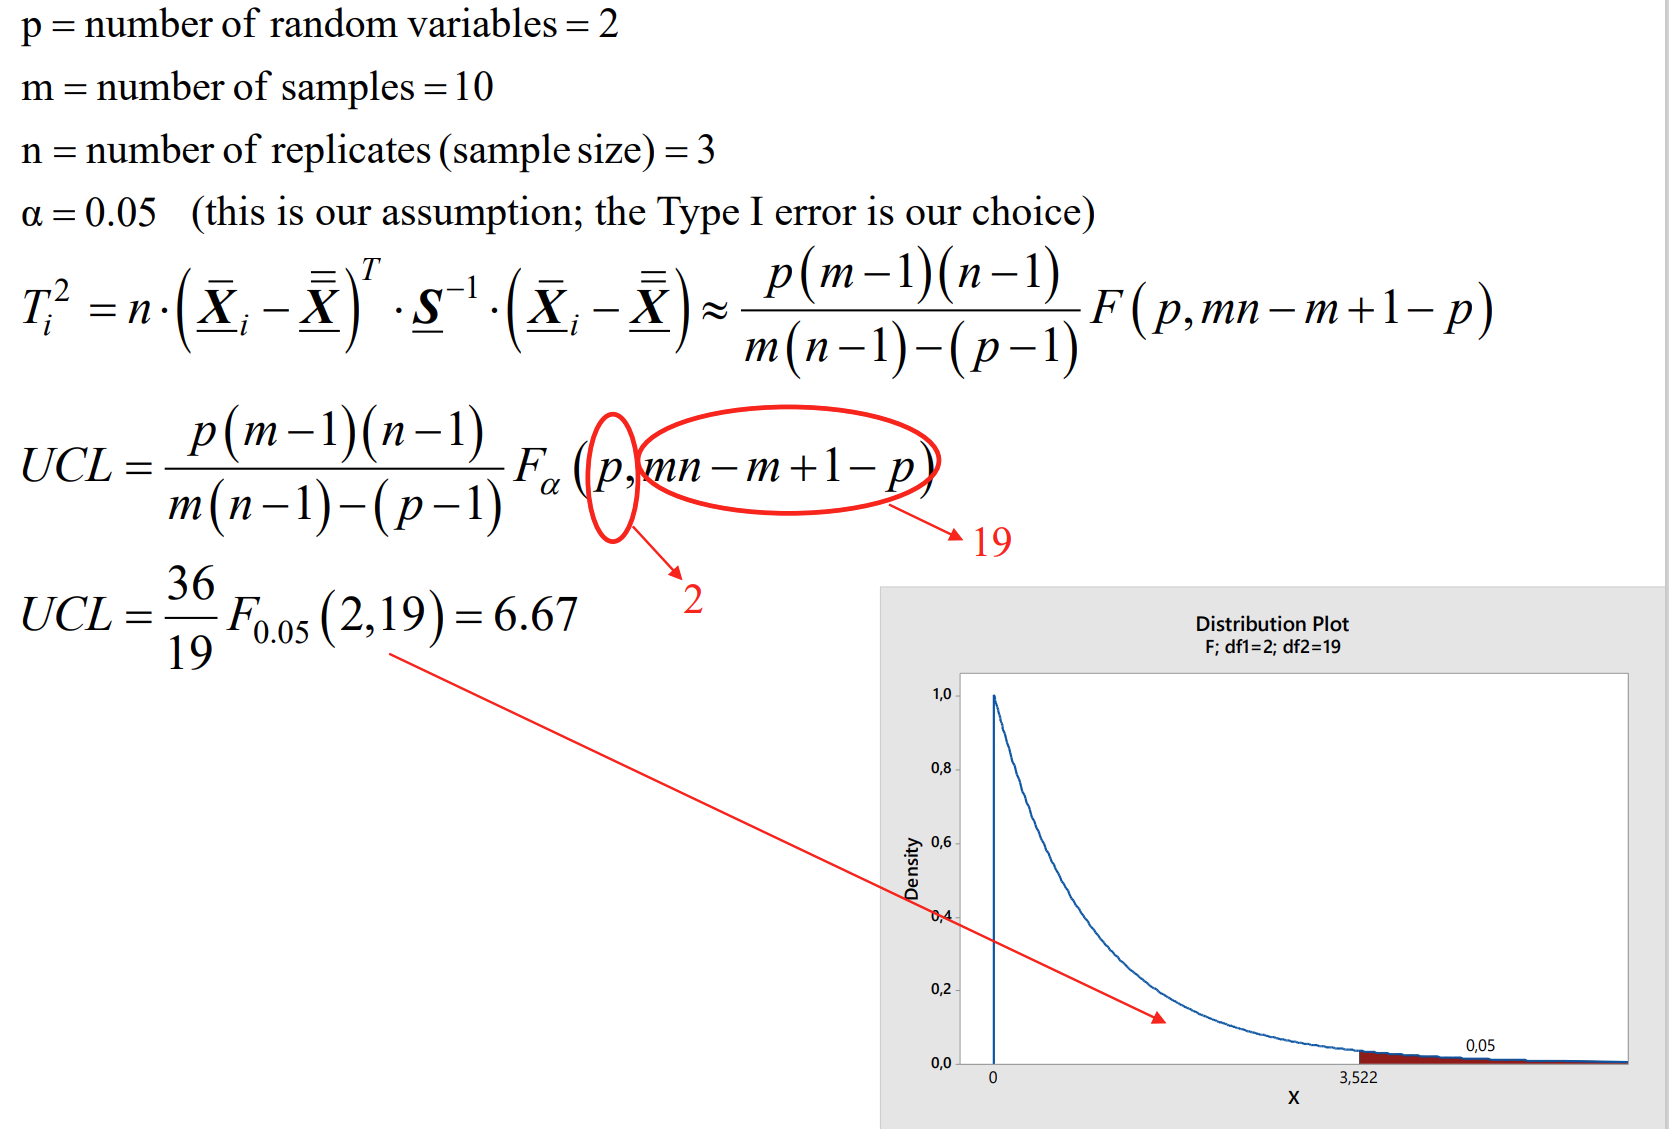

In [11]:
p = 2           # number of random variables
m = 10          # number of samples
n = 3           # number of replicates (sample size)
alpha = 0.05    # significance level

UCL = (p * (m-1) * (n-1)) / (m * (n-1) - (p-1)) * stats.f.ppf(1-alpha, p, m*n - m + 1 - p)

print('UCL = %.3f' % UCL)

UCL = 6.673


> Let's evaluate if the 9th sample is in control
>
> Remember that the sample is IC if  
T<sup>2</sup><sub>i</sub> < UCL

In [12]:
# Calculate the Hotelling T2 statistic for the 9th sample
index = 8
S_inv = np.linalg.inv(S)
T2 = n * (sample_mean.iloc[index]-Xbarbar).transpose().dot(S_inv).dot(sample_mean.iloc[index]-Xbarbar)

print('\nThe Hotelling T2 statistic for the sample number %d is: %.3f' % (index + 1, T2))


The Hotelling T2 statistic for the sample number 9 is: 0.424


> The 9th sample in therefore in control

> We can extend this analysis to the other samples.

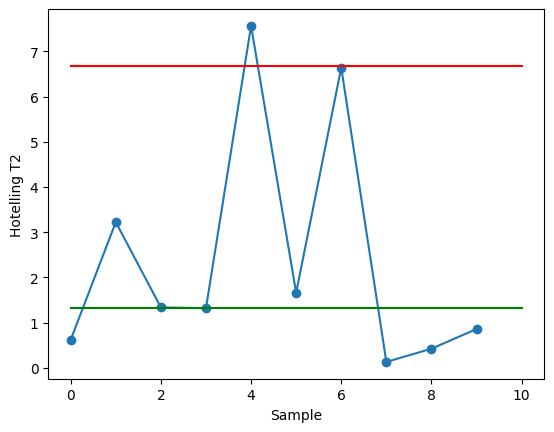

In [13]:
# Calculate the Hotelling T2 statistic for all the samples
T2 = []
for i in range(m):
    T2.append(n * (sample_mean.iloc[i]-Xbarbar).transpose().dot(S_inv).dot(sample_mean.iloc[i]-Xbarbar))

# Plot the Hotelling T2 statistic
plt.plot(T2, 'o-')
plt.plot([0, m], [UCL, UCL], 'r-')
plt.plot([0, m], [np.median(T2), np.median(T2)], 'g-')
plt.xlabel('Sample')
plt.ylabel('Hotelling T2')
plt.show()

In [14]:
data_stack.head()

sample  width  corr_speed
0       0   2.14        0.33
1       0   2.01        0.47
2       0   1.88        0.50
3       1   1.96        0.37
4       1   1.91        0.62

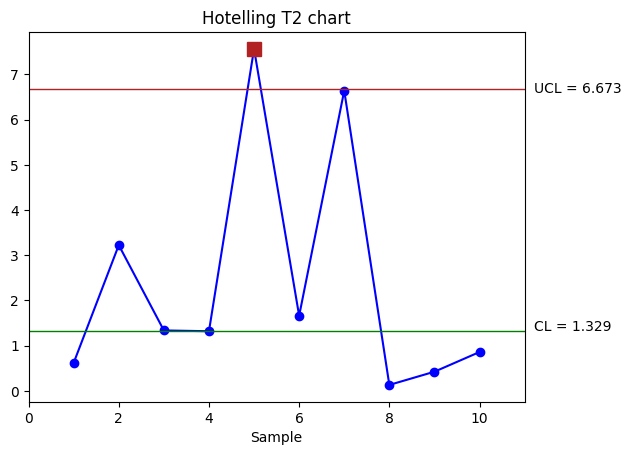

sample     width  corr_speed        T2       UCL   T2_TEST
sample_id                                                            
1.0           0.0  2.010000    0.433333  0.621015  6.673061       NaN
2.0           1.0  1.936667    0.453333  3.223921  6.673061       NaN
3.0           2.0  1.926667    0.500000  1.337552  6.673061       NaN
4.0           3.0  1.920000    0.563333  1.319900  6.673061       NaN
5.0           4.0  2.080000    0.506667  7.563583  6.673061  7.563583
6.0           5.0  1.906667    0.526667  1.662429  6.673061       NaN
7.0           6.0  2.110000    0.456667  6.640925  6.673061       NaN
8.0           7.0  1.973333    0.480000  0.132247  6.673061       NaN
9.0           8.0  1.950000    0.496667  0.424402  6.673061       NaN
10.0          9.0  2.040000    0.420000  0.859660  6.673061       NaN

In [15]:
import qda
qda.ControlCharts.T2hotelling(data_stack, ['width', 'corr_speed'], sample_size = (10, 3), alpha = 0.05)

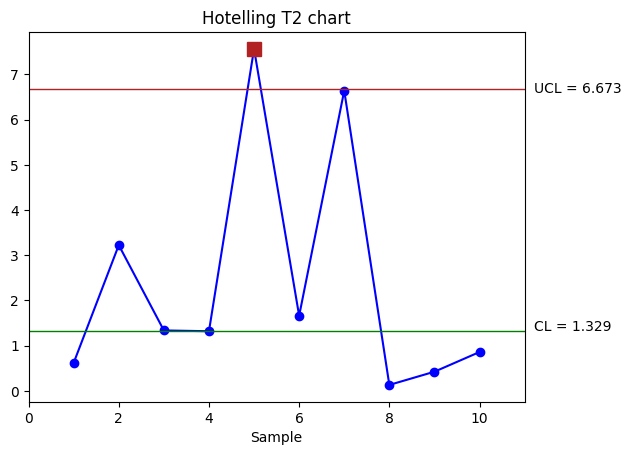

In [18]:
original_df = data_stack
col_names = ['width', 'corr_speed']
sample_size = 3
mean = None
varcov = None
alpha = 0.05
plotit = True
m = len(original_df) / sample_size
# check if it is an integer
if abs(m - round(m)) != 0:
    raise ValueError('The sample size must be a factor of the number of rows in the DataFrame.')
else:
    m = int(m)

# number of variables
p = len(col_names)

# number of observations
n = sample_size

original_df['sample_id'] = np.repeat(np.arange(1, len(original_df)/sample_size+1), sample_size)

if mean is None:
    # group by sample_id to calculate the mean within each sample
    sample_mean = original_df.groupby('sample_id').mean()

    # compute the grand mean
    Xbarbar = sample_mean.mean()

    # reorder the columns to match the order of the columns in the DataFrame
    Xbarbar = Xbarbar.reindex(index=col_names)

if varcov is None:
    # Compute the variance and covariance matrix of each group (sample)
    cov_matrix = original_df.groupby('sample_id').cov()
    
    # Compute the mean covariance matrix
    S = cov_matrix.groupby(level=1).mean()
    
    # reorder the columns to match the order of the columns in the DataFrame
    S = S.reindex(columns=col_names, index=col_names)

# Calculate the Hotelling T2 statistic for all the samples
# Initialize the list to store the T2 values
sample_mean['T2'] = np.nan

# calculate the inverse of the covariance matrix
S_inv = np.linalg.inv(S)

for i in range(m):
    sample_mean['T2'].iloc[i] = n * (sample_mean[col_names].iloc[i]-Xbarbar).transpose().dot(S_inv).dot(sample_mean[col_names].iloc[i]-Xbarbar)

# Calculate the upper control limit
UCL = (p * (m-1) * (n-1)) / (m * (n-1) - (p-1)) * stats.f.ppf(1-alpha, p, m*n - m + 1 - p)
# add the UCL to the DataFrame
sample_mean['UCL'] = UCL

# Add a column with the test
sample_mean['T2_TEST'] = np.where(sample_mean['T2'] > UCL, sample_mean['T2'], np.nan)

# Plot the Hotelling T2 statistic
if plotit == True:
    plt.plot(sample_mean['T2'], color='b', linestyle='-', marker='o')
    plt.hlines(UCL, 0, m+1, color='firebrick', linewidth=1)
    plt.hlines(np.median(sample_mean['T2']), 0, m+1, color='g', linewidth=1)
    plt.plot(sample_mean['T2_TEST'], linestyle='none', marker='s', color='firebrick', markersize=10)
    plt.title('Hotelling T2 chart')
    plt.text(m+1.2, UCL, 'UCL = {:.3f}'.format(UCL), verticalalignment='center')
    plt.text(m+1.2, np.median(sample_mean['T2']), 'CL = {:.3f}'.format(np.median(sample_mean['T2']), verticalalignment='center'))
    plt.xlim(0, m+1)
    plt.xlabel('Sample')
    plt.show()